# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_table('AZDIAS_Feature_Summary.csv',sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [5]:
azdias.shape

(891221, 85)

In [6]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,ZABEOTYP,person,ordinal,[-1]
freq,1,43,49,26


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Identify missing or unknown data values and convert them to NaNs.

print('Number of missing values in data is {}'.format(azdias.isnull().sum().sum()))
azdias.isnull().sum()

Number of missing values in data is 4896838


AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [8]:
feat_info['missing_or_unknown']

0       [-1,0]
1     [-1,0,9]
2       [-1,0]
3          [0]
4         [-1]
5         [-1]
6         [-1]
7         [-1]
8         [-1]
9         [-1]
10        [-1]
11         [0]
12          []
13          []
14      [-1,0]
15         [0]
16         [0]
17         [0]
18         [0]
19         [0]
20         [0]
21      [-1,0]
22      [-1,0]
23         [0]
24      [-1,9]
25      [-1,9]
26      [-1,9]
27      [-1,9]
28      [-1,9]
29      [-1,9]
        ...   
55        [-1]
56        [-1]
57      [-1,X]
58        [XX]
59     [-1,XX]
60        [-1]
61        [-1]
62        [-1]
63        [-1]
64      [-1,0]
65      [-1,0]
66        [-1]
67        [-1]
68        [-1]
69          []
70      [-1,0]
71          []
72          []
73      [-1,0]
74          []
75        [-1]
76        [-1]
77        [-1]
78        [-1]
79      [-1,0]
80        [-1]
81        [-1]
82      [-1,9]
83      [-1,0]
84      [-1,9]
Name: missing_or_unknown, Length: 85, dtype: object

In [9]:
for indx in range(len(feat_info)):
    missing_or_unknown = feat_info.iloc[indx]['missing_or_unknown']
    missing_or_unknown = missing_or_unknown.strip('[]')
    missing_or_unknown = missing_or_unknown.split(sep = ',')
    missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
    if missing_or_unknown != ['']:
        azdias = azdias.replace({feat_info.iloc[indx]['attribute'] : missing_or_unknown}, np.nan)

In [10]:
if 'XX' in azdias.values:
    print("yes")

In [11]:
print('Number of missing values after conversion is {}'.format(azdias.isnull().sum().sum()))

Number of missing values after conversion is 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [12]:
len(azdias)
azdias.isnull().sum() / len(azdias) * 100

AGER_TYP                 76.955435
ALTERSKATEGORIE_GROB      0.323264
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT          

In [13]:
azdias.count()

AGER_TYP                 205378
ALTERSKATEGORIE_GROB     888340
ANREDE_KZ                891221
CJT_GESAMTTYP            886367
FINANZ_MINIMALIST        891221
FINANZ_SPARER            891221
FINANZ_VORSORGER         891221
FINANZ_ANLEGER           891221
FINANZ_UNAUFFAELLIGER    891221
FINANZ_HAUSBAUER         891221
FINANZTYP                891221
GEBURTSJAHR              498903
GFK_URLAUBERTYP          886367
GREEN_AVANTGARDE         891221
HEALTH_TYP               780025
LP_LEBENSPHASE_FEIN      793589
LP_LEBENSPHASE_GROB      796649
LP_FAMILIE_FEIN          813429
LP_FAMILIE_GROB          813429
LP_STATUS_FEIN           886367
LP_STATUS_GROB           886367
NATIONALITAET_KZ         782906
PRAEGENDE_JUGENDJAHRE    783057
RETOURTYP_BK_S           886367
SEMIO_SOZ                891221
SEMIO_FAM                891221
SEMIO_REL                891221
SEMIO_MAT                891221
SEMIO_VERT               891221
SEMIO_LUST               891221
                          ...  
OST_WEST

In [14]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
percent_missing_each_column = azdias.isnull().sum() / len(azdias) * 100


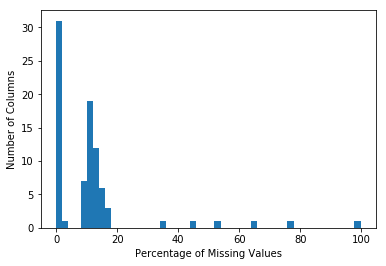

In [15]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(percent_missing_each_column, bins = 50)
plt.ylabel('Number of Columns')
plt.xlabel('Percentage of Missing Values')
plt.show()

In [16]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

percent_missing_greater_than_20 = percent_missing_each_column[percent_missing_each_column > 20]
len(percent_missing_greater_than_20)

columns_to_be_dropped = percent_missing_greater_than_20.index.tolist()
columns_to_be_dropped

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [17]:
azdias = azdias.drop(columns_to_be_dropped, axis = 1)
feat_info = feat_info[~feat_info['attribute'].isin(columns_to_be_dropped)]
feat_info.shape

(79, 4)

In [18]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)


Out of 85 columns only 6 columns have missing values greater than 20%. The columns to be dropped are 
'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

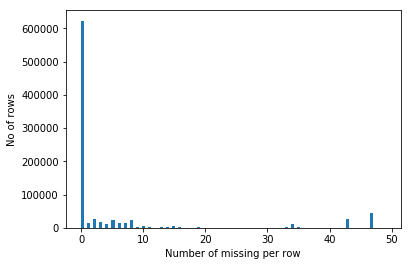

In [19]:
# How much data is missing in each row of the dataset?
no_of_missing_per_row = azdias.isnull().sum(axis = 1)
plt.hist(no_of_missing_per_row, bins = 100)
plt.xlabel('Number of missing per row')
plt.ylabel('No of rows')
plt.show()

In [20]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias_missing_lt_3 = azdias[azdias.isnull().sum(axis=1) <= 3]
print(len(azdias_missing_lt_3))
azdias_missing_mt_3 = azdias[azdias.isnull().sum(axis=1) > 3]
print(len(azdias_missing_mt_3))

684502
206719


In [21]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

percent_missing_zero = percent_missing_each_column[percent_missing_each_column == 0].index
percent_missing_zero = np.random.choice(percent_missing_zero, 5, replace = False)
percent_missing_zero.tolist()

['FINANZ_MINIMALIST',
 'FINANZTYP',
 'FINANZ_ANLEGER',
 'FINANZ_SPARER',
 'SEMIO_VERT']

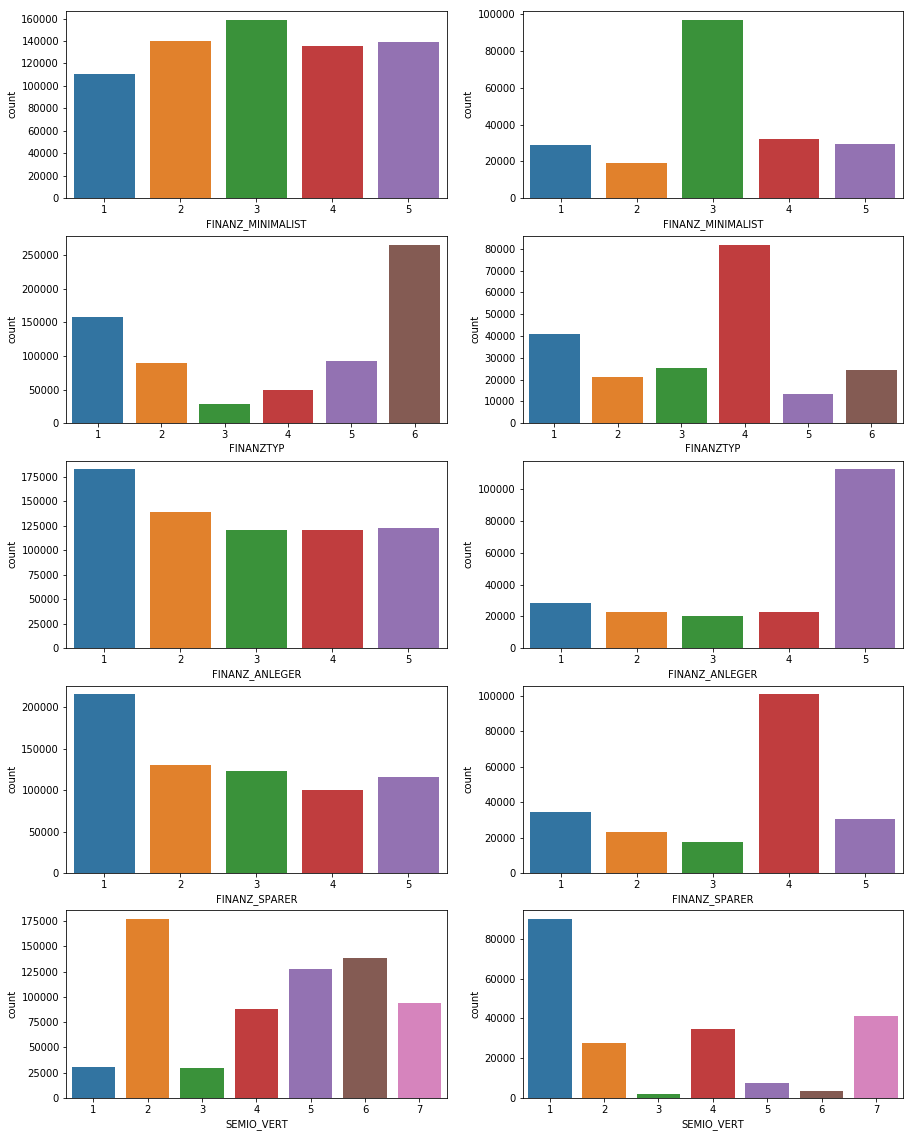

In [22]:
def plot_difference(col, idx,figure, axs):
    sns.countplot(azdias_missing_lt_3[col], ax=axs[idx][0])
    sns.countplot(azdias_missing_mt_3[col], ax=axs[idx][1])

figure, axs = plt.subplots(nrows=len(percent_missing_zero), ncols=2, figsize = (15,20))
for idx,col in enumerate(percent_missing_zero):
    plot_difference(col, idx,figure, axs)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

The data with lots of missing values are qualitatively different from data with less missing values. The distribution of data with more missing values is skewed i.e The count plot is shows the count is skewed to single value. I feel we cannot get enough information with this data, so I have decided to drop rows with more than 3 missing values


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [23]:
# How many features are there of each data type?

feat_info.groupby('type').count()

,attribute,information_level,missing_or_unknown
type,,,
categorical,18,18,18
mixed,6,6,6
numeric,6,6,6
ordinal,49,49,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [24]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical = feat_info[feat_info['type'] == 'categorical']['attribute'].values
categorical = [x for x in categorical if x in azdias.columns] # only the ones that are kept in azdias dataset
binary = [x for x in categorical if azdias[x].nunique()==2]
multilevel = [x for x in categorical if azdias[x].nunique()>2]
azdias[categorical].nunique()
print(len(binary))
print(len(multilevel))

5
13


In [25]:
feat_info

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]
10,FINANZTYP,person,categorical,[-1]


In [26]:
for feature in binary:
    print('Unique values for binary feature {} are {}'.format(feature, azdias_missing_lt_3[feature].unique()))

Unique values for binary feature ANREDE_KZ are [2 1]
Unique values for binary feature GREEN_AVANTGARDE are [0 1]
Unique values for binary feature SOHO_KZ are [ 1.  0.]
Unique values for binary feature VERS_TYP are [ 2.  1.]
Unique values for binary feature OST_WEST_KZ are ['W' 'O']


In [27]:
binary_values = {'W': 0, 'O' : 1}
azdias_clean_binary = azdias_missing_lt_3.replace({'OST_WEST_KZ' : binary_values})
azdias_clean_binary['OST_WEST_KZ'].unique()

array([0, 1])

In [28]:
azdias_clean_binary.shape

(684502, 79)

In [29]:
# Re-encode categorical variable(s) to be kept in the analysis.
type(multilevel)

list

In [30]:
azdias_remove_multilevel = azdias_clean_binary.drop(multilevel, axis = 1)
azdias_remove_multilevel.shape

(684502, 66)

In [31]:
azdias_clean = azdias_remove_multilevel

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

- Re-encoded the values of OST_WEST_KZ to 0 and 1
- Decided to drop multilevel values
- Decided to keep all binary features ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ, OST_WEST_KZ, VERS_TYP

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [32]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_clean['DECADE'] = azdias_clean['PRAEGENDE_JUGENDJAHRE']
azdias_clean['MOVEMENT'] = azdias_clean['PRAEGENDE_JUGENDJAHRE']

In [33]:
decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

In [34]:
azdias_clean['DECADE'].replace(decade_dict, inplace = True)
azdias_clean['MOVEMENT'].replace(decade_dict, inplace = True)

In [35]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_clean['WEALTH'] = azdias_clean['CAMEO_INTL_2015']
azdias_clean['LIFE_STAGE'] = azdias_clean['CAMEO_INTL_2015']

In [36]:
wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}
life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}

In [37]:
azdias_clean['WEALTH'].replace(wealth_dict, inplace = True)
azdias_clean['LIFE_STAGE'].replace(life_stage_dict, inplace = True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

Created a dict of values by looking at the data dictionary.

Split PRAEGENDE_JUGENDJAHRE into new columns DECADE and MOVEMENT, assigned PRAEGENDE_JUGENDJAHRE to DECADE and MOVEMENT and then did inplace replace with values from data dictionary (decade_dict and movement_dict)

Split CAMEO_INTL_2015 into new columns WEALTH and LIFE_STAGE, assigned CAMEO_INTL_2015 to DECADE and MOVEMENT and then did inplace replace with values from data dictionary (wealth_dict and life_stage_dict)

Decided to drop other four mixed features

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [38]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,6.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,6.0,6.0,2.0,4.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,4.0,4.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,2.0,5.0,4.0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,1.0,5.0,5.0,4.0,6.0,3.0,5.0,5.0,2.0,2.0


In [39]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
mixed = feat_info[feat_info['type'] == 'mixed']['attribute'].values
azdias_clean = azdias_clean.drop(mixed, axis = 1)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [40]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    feat_info = pd.read_table('AZDIAS_Feature_Summary.csv',sep=';')
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for indx in range(len(feat_info)):
        missing_or_unknown = feat_info.iloc[indx]['missing_or_unknown']
        missing_or_unknown = missing_or_unknown.strip('[]')
        missing_or_unknown = missing_or_unknown.split(sep = ',')
        missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
        if missing_or_unknown != ['']:
            df_clean = df.replace({feat_info.iloc[indx]['attribute'] : missing_or_unknown}, np.nan)
    
    for col in df.columns:
        df_clean = df_clean.replace({col: ['XX', 'X']}, np.nan)
    # remove selected columns and rows, ...
    percent_missing_each_column = df_clean.isnull().sum() / len(azdias) * 100
    percent_missing_greater_than_20 = percent_missing_each_column[percent_missing_each_column > 20]
    columns_to_be_dropped = percent_missing_greater_than_20.index.tolist()
    
    df_clean = df_clean.drop(columns_to_be_dropped, axis = 1)
    feat_info_clean = feat_info[~feat_info['attribute'].isin(columns_to_be_dropped)]
    df_clean = df_clean[df_clean.isnull().sum(axis=1) <= 3]
    # select, re-encode, and engineer column values.
    df_clean = df_clean.replace({'OST_WEST_KZ' : binary_values})
    df_clean = df_clean.drop(multilevel, axis = 1)
    df_clean['DECADE'] = df_clean['PRAEGENDE_JUGENDJAHRE']
    df_clean['MOVEMENT'] = df_clean['PRAEGENDE_JUGENDJAHRE']
    df_clean['WEALTH'] = df_clean['CAMEO_INTL_2015']
    df_clean['LIFE_STAGE'] = df_clean['CAMEO_INTL_2015']
    decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
    wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}
    life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}
    df_clean['DECADE'].replace(decade_dict, inplace = True)
    df_clean['MOVEMENT'].replace(decade_dict, inplace = True)
    df_clean['WEALTH'].replace(wealth_dict, inplace = True)
    df_clean['LIFE_STAGE'].replace(life_stage_dict, inplace = True)
    mixed = feat_info_clean[feat_info_clean['type'] == 'mixed']['attribute'].values
    df_clean = df_clean.drop(mixed, axis = 1)
    # Return the cleaned dataframe.
    return df_clean
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [41]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

imputer = Imputer()
azdias_clean_imputed = pd.DataFrame(imputer.fit_transform(azdias_clean), columns = azdias_clean.columns)

In [42]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
azdias_clean_scaled = pd.DataFrame(scaler.fit_transform(azdias_clean_imputed), columns = azdias_clean.columns)
azdias_clean_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-1.747634,0.975423,-1.523655,1.588878,-1.050212,1.513292,1.048651,1.341142,-0.542999,1.038860,...,0.409122,1.432172,0.564740,-0.184173,-0.134541,0.678627,1.163882,1.163882,1.177393,-1.264331
1,0.193497,0.975423,-1.523655,0.908468,-1.771419,-0.548762,0.320698,1.341142,1.841624,1.038860,...,-0.963869,0.402503,0.564740,-0.184173,-0.134541,-0.799400,1.163882,1.163882,-0.870894,0.750853
2,0.193497,-1.025197,0.677626,0.228057,0.392200,-1.236113,0.320698,-0.834925,-0.542999,1.038860,...,0.409122,-0.627167,-0.334972,0.822460,0.301241,1.417641,-0.222748,-0.222748,0.494631,0.079125
3,-1.747634,0.975423,-0.056134,-1.132765,1.113406,-0.548762,-0.407255,1.341142,-0.542999,1.038860,...,0.409122,1.432172,1.464451,-1.190806,-1.006105,-0.060386,-1.609378,-1.609378,1.177393,0.750853
4,-0.777068,0.975423,-1.523655,1.588878,-1.771419,1.513292,1.048651,-0.109569,-0.542999,-0.285764,...,-0.963869,1.432172,1.464451,0.822460,0.301241,-0.060386,0.470567,0.470567,-0.870894,-0.592603


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

Replaced the missing values with mean of the column using sklearn Imputer. Scaled the values using StandardScaler

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [43]:
# Apply PCA to the data.

pca = PCA()
pca.fit(azdias_clean_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

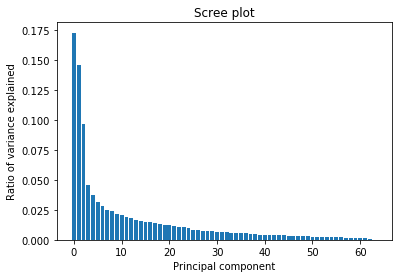

In [44]:
# Investigate the variance accounted for by each principal component.
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Scree plot")
plt.xlabel("Principal component")
plt.ylabel("Ratio of variance explained")
plt.show()

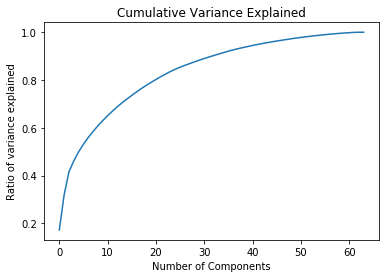

In [45]:
plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), '-')
plt.title("Cumulative Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("Ratio of variance explained")
plt.show()

In [46]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_30 = PCA(n_components=30)
azdias_pca = pca_30.fit_transform(azdias_clean_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

I decided to retain first 30 components for PCA. By looking at the Number of components vs Cumulative Variance explained it is clear that the 30 components explained 88% of the variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [47]:
def pca_weights(pca, component):
    df = pd.DataFrame(pca.components_, columns = list(azdias_clean_scaled.columns))
    weights = df.iloc[component].sort_values(ascending=False)
    return weights

In [48]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
pca_weights(pca_30, 0)

PLZ8_ANTG3               0.199776
PLZ8_ANTG4               0.193875
FINANZ_SPARER            0.191596
WEALTH                   0.182315
HH_EINKOMMEN_SCORE       0.181081
ORTSGR_KLS9              0.174285
EWDICHTE                 0.171835
MOVEMENT                 0.158655
DECADE                   0.158655
SEMIO_PFLICHT            0.156649
SEMIO_REL                0.156477
SEMIO_TRADV              0.140073
PLZ8_ANTG2               0.135146
KBA05_ANTG4              0.133843
SEMIO_RAT                0.129132
FINANZ_HAUSBAUER         0.127323
ARBEIT                   0.125598
FINANZ_UNAUFFAELLIGER    0.123636
KBA05_ANTG3              0.122426
ANZ_HAUSHALTE_AKTIV      0.119397
RELAT_AB                 0.117052
SEMIO_KULT               0.110908
SEMIO_MAT                0.110123
SEMIO_FAM                0.107979
FINANZ_ANLEGER           0.107133
REGIOTYP                 0.062702
SEMIO_SOZ                0.061120
OST_WEST_KZ              0.048155
HEALTH_TYP               0.040159
PLZ8_HHZ      

In [49]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weights(pca_30, 1)

ALTERSKATEGORIE_GROB     0.216440
FINANZ_VORSORGER         0.194735
SEMIO_ERL                0.188720
RETOURTYP_BK_S           0.155394
SEMIO_LUST               0.152674
FINANZ_HAUSBAUER         0.149477
PLZ8_ANTG3               0.146751
PLZ8_ANTG4               0.140938
EWDICHTE                 0.136228
ORTSGR_KLS9              0.135688
W_KEIT_KIND_HH           0.126778
WEALTH                   0.121611
KBA05_ANTG4              0.105084
SEMIO_KRIT               0.101025
ARBEIT                   0.100280
PLZ8_ANTG2               0.099615
HH_EINKOMMEN_SCORE       0.098258
SEMIO_KAEM               0.097306
RELAT_AB                 0.094843
ANZ_HAUSHALTE_AKTIV      0.092846
KBA05_ANTG3              0.078355
ANREDE_KZ                0.068675
SEMIO_DOM                0.053449
WOHNDAUER_2008           0.041167
OST_WEST_KZ              0.040141
REGIOTYP                 0.037856
ANZ_HH_TITEL             0.037672
VERS_TYP                 0.033386
PLZ8_HHZ                 0.023566
FINANZ_MINIMAL

In [50]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weights(pca_30, 2)

SEMIO_VERT               0.350222
SEMIO_SOZ                0.269997
SEMIO_FAM                0.265580
SEMIO_KULT               0.250768
FINANZ_MINIMALIST        0.148425
SEMIO_REL                0.102952
RETOURTYP_BK_S           0.102692
W_KEIT_KIND_HH           0.086281
FINANZ_VORSORGER         0.082440
SEMIO_MAT                0.067124
ALTERSKATEGORIE_GROB     0.060711
SEMIO_LUST               0.057631
GREEN_AVANTGARDE         0.037735
PLZ8_ANTG4               0.037097
PLZ8_ANTG3               0.036108
ORTSGR_KLS9              0.035354
EWDICHTE                 0.035351
WOHNDAUER_2008           0.029960
ARBEIT                   0.026246
RELAT_AB                 0.024081
PLZ8_ANTG2               0.023880
KBA05_ANTG4              0.023581
WEALTH                   0.023059
ANZ_HAUSHALTE_AKTIV      0.022299
VERS_TYP                 0.017773
OST_WEST_KZ              0.011772
ANZ_HH_TITEL             0.011039
ANZ_TITEL                0.008622
KBA05_ANTG3              0.005862
PLZ8_HHZ      

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

Principal Component 0:
PLZ8_ANTG3 (6 - 10 families in the PLZ8 region) - Positive
FINANZ_SPARER (Money saver)- Positive
FINANZ_MINIMALIST (Don't care about money)- Negative
MOBI_REGIO (movement) - Negative
This makes as families save money, more movement means younger population who spends as lot and don't live in families.

Principal Component 1:
'ALTERSKATEGORIE_GROB' (age) with positive weight 
as opposed 'DECADE' (decade) with negative weight. 
if 'DECADE' is higher which means population is younger, the 'ALTERSKATEGORIE_GROB' goes down which means getting younger.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [51]:
# Over a number of different cluster counts...

def run_kmeans(data, n):

    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters = n)
    model = kmeans.fit(data)
    # compute the average within-cluster distances.
    score = np.abs(model.score(data)) # take abs since score is negative of k means objective
    return score

In [52]:
#Investigate the change in within-cluster distance across number of clusters.
#HINT: Use matplotlib's plot function to visualize this relationship.
scores = []

for n in range(1,20):
    scores.append(run_kmeans(azdias_pca, n))

Text(0,0.5,'K means objective')

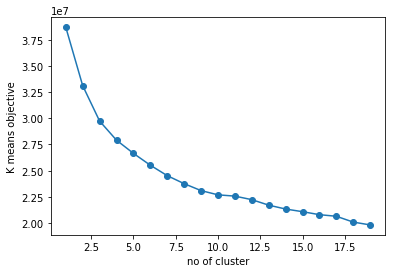

In [53]:
plt.plot(list(range(1,20)), scores, linestyle='-', marker='o')
plt.xlabel('no of cluster')
plt.ylabel('K means objective')

In [117]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters = 15)
model_kmeans = kmeans.fit(azdias_pca)
prediction = model_kmeans.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

I decided to go with 10 clusters, it is at around 10 clusters or more I started getting diminishing returns with the increase in clusters

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [118]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.shape

(191652, 85)

In [119]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean = clean_data(customers)
customers_clean.shape

(131203, 69)

In [120]:
customers_clean_imputed = pd.DataFrame(imputer.transform(customers_clean))
customers_clean_imputed.shape

(131203, 69)

In [121]:
customers_clean_scaled = scaler.transform(customers_clean_imputed)
customers_clean_scaled = pd.DataFrame(customers_clean_scaled, columns = list(customers_clean_imputed))

In [122]:
customers_pca = pca_30.transform(customers_clean_scaled)

In [123]:
customers_predict = model_kmeans.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

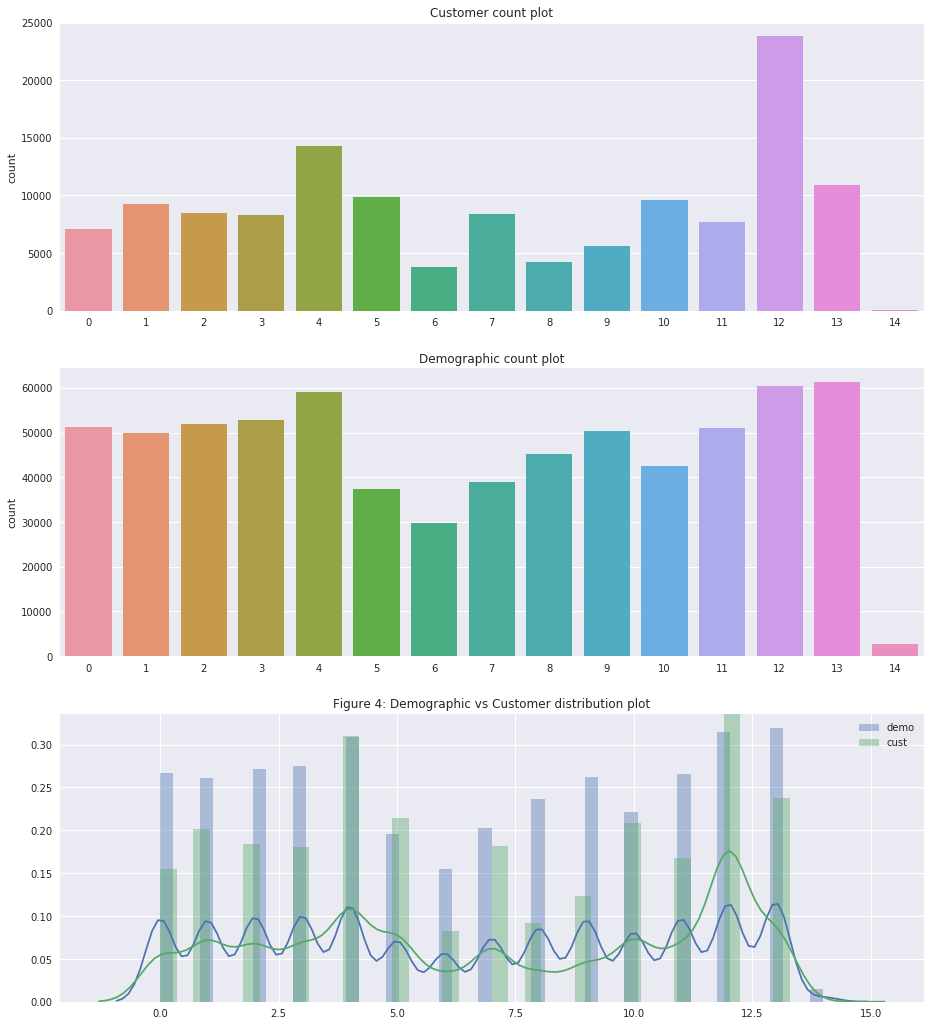

In [124]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

fig = plt.figure()
ax=fig.add_axes([0,0,2,1], title='Figure 4: Demographic vs Customer distribution plot')
ax2=fig.add_axes([0,1.2,2,1], title='Demographic count plot')
ax3=fig.add_axes([0,2.4,2,1], title='Customer count plot')
sns.set(style="darkgrid")
sns.distplot(prediction, label='demo',ax=ax)
sns.distplot(customers_predict, label='cust', ax=ax)
sns.countplot(prediction, label='demo', ax=ax2)
sns.countplot(customers_predict, label='cust', ax=ax3)
ax.legend();

In [127]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

centroid_12 = scaler.inverse_transform(pca_30.inverse_transform(model_kmeans.cluster_centers_[12]))
overrepresented_data = pd.Series(data = centroid_12, index = customers_clean.columns)
overrepresented_data

AGER_TYP                    1.238683
ALTERSKATEGORIE_GROB        3.585884
ANREDE_KZ                   0.924686
FINANZ_MINIMALIST           5.369658
FINANZ_SPARER               0.973203
FINANZ_VORSORGER            4.936376
FINANZ_ANLEGER              0.977718
FINANZ_UNAUFFAELLIGER       1.588420
FINANZ_HAUSBAUER            1.865355
GEBURTSJAHR              1324.004767
GREEN_AVANTGARDE            0.944397
HEALTH_TYP                  1.501318
RETOURTYP_BK_S              4.017641
SEMIO_SOZ                   5.011324
SEMIO_FAM                   4.828736
SEMIO_REL                   4.058846
SEMIO_MAT                   5.093751
SEMIO_VERT                  6.699612
SEMIO_LUST                  6.123510
SEMIO_ERL                   3.508998
SEMIO_KULT                  5.164159
SEMIO_RAT                   2.752579
SEMIO_KRIT                  2.411696
SEMIO_DOM                   2.919843
SEMIO_KAEM                  1.774931
SEMIO_PFLICHT               2.980403
SEMIO_TRADV                 3.380785
S

In [129]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
centroid_8 = scaler.inverse_transform(pca_30.inverse_transform(model_kmeans.cluster_centers_[8]))
underrepresented_data = pd.Series(data = centroid_8, index = customers_clean.columns)
underrepresented_data

AGER_TYP                    2.337647
ALTERSKATEGORIE_GROB        4.213288
ANREDE_KZ                   1.544269
FINANZ_MINIMALIST           4.904971
FINANZ_SPARER               0.145839
FINANZ_VORSORGER            5.824076
FINANZ_ANLEGER              0.664594
FINANZ_UNAUFFAELLIGER       0.838730
FINANZ_HAUSBAUER            3.258118
GEBURTSJAHR              1236.070836
GREEN_AVANTGARDE            0.535050
HEALTH_TYP                  1.799646
RETOURTYP_BK_S              4.570276
SEMIO_SOZ                   3.646015
SEMIO_FAM                   2.715285
SEMIO_REL                   1.677169
SEMIO_MAT                   1.667052
SEMIO_VERT                  4.652535
SEMIO_LUST                  6.830964
SEMIO_ERL                   6.586911
SEMIO_KULT                  2.516305
SEMIO_RAT                   1.928441
SEMIO_KRIT                  4.488392
SEMIO_DOM                   4.095847
SEMIO_KAEM                  4.351500
SEMIO_PFLICHT               1.931586
SEMIO_TRADV                 1.923670
S

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)


From the anaylsis above, it can be seen that

Cluster 12 is overrepresented in the customers data compared to general population data. Some characteristics of the group of population that are relative popular with the mail-order company:

Wealthy households (WEALTH = 1.465)
Elderly people (Passively and culturaly elderly) (AGER_TYP=1.238683)
in areas where the share of 6-10 family homes is lower (PLZ8_ANTG3=1.041491)
Older Families & Mature Couples (LIFE_STAGE=4.117302)

Cluster 8 is underrepresented in the customers data. Some characteristics of the segment of the population that are relatively unpopular with the company:

Represent people more than 60 year olds 
Represent people in properous families and also old families and mature couples.
Lower movement


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.